In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt

In [3]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """
    labels = [str(filepath[i]).split("/")[-2]
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    return df

In [2]:
train_dir = Path('train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [4]:
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [7]:
train_df.head(5)

,Filepath,Label
0,train/soy beans/Image_41.jpg,soy beans
1,train/capsicum/Image_1.jpg,capsicum
2,train/paprika/Image_41.jpg,paprika
3,train/soy beans/Image_67.jpg,soy beans
4,train/sweetpotato/Image_60.jpg,sweetpotato


In [8]:
test_df.head(5)

,Filepath,Label
0,test/capsicum/Image_2.jpg,capsicum
1,test/spinach/Image_6.jpg,spinach
2,test/mango/Image_3.jpg,mango
3,test/beetroot/Image_2.jpg,beetroot
4,test/banana/Image_5.jpg,banana


In [9]:
val_df.head(5)

,Filepath,Label
0,test/watermelon/Image_1.jpg,watermelon
1,test/peas/Image_5.jpg,peas
2,test/onion/Image_2.jpg,onion
3,test/capsicum/Image_10.jpg,capsicum
4,test/tomato/Image_4.jpg,tomato


In [10]:
train_df.describe(include="all")

,Filepath,Label
count,2780,2780
unique,2780,36
top,train/soy beans/Image_41.jpg,soy beans
freq,1,92


In [11]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

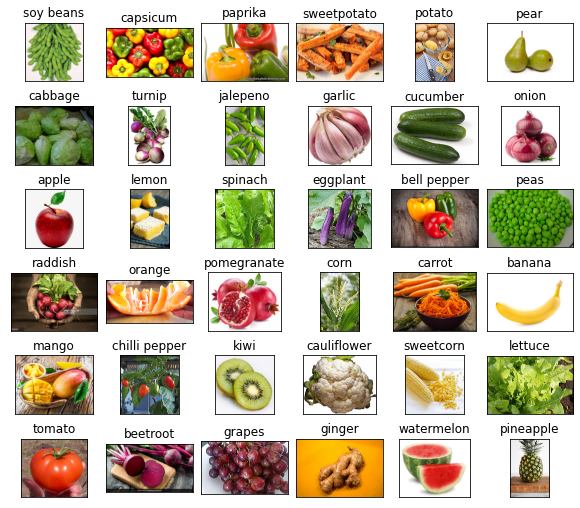

In [12]:
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()